In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModel
from datasets import Dataset
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP電商專案/資料爬蟲/final227.csv')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/21120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5280 [00:00<?, ? examples/s]

Map:   0%|          | 0/6600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.264200,0.247594,0.899432,0.899627,0.899432,0.899484,"[[1556, 15, 189], [16, 1695, 49], [223, 39, 1498]]"
2,0.268300,0.262013,0.911174,0.911548,0.911174,0.911098,"[[1610, 18, 132], [12, 1695, 53], [217, 37, 1506]]"
3,0.122000,0.351770,0.913258,0.912914,0.913258,0.912375,"[[1588, 36, 136], [8, 1740, 12], [160, 106, 1494]]"


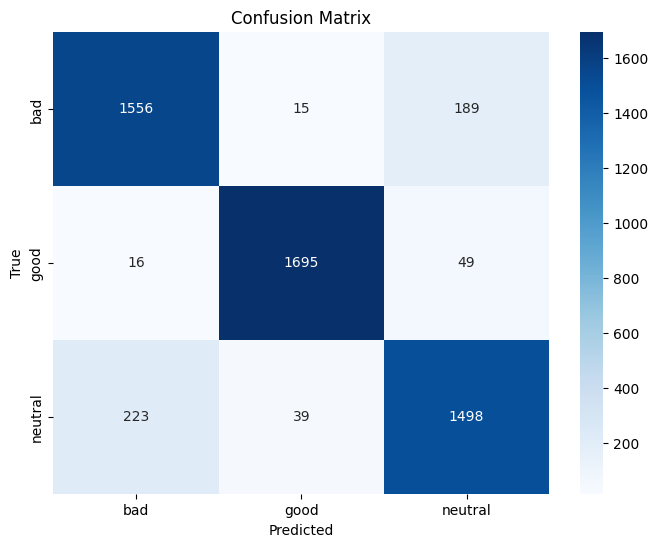

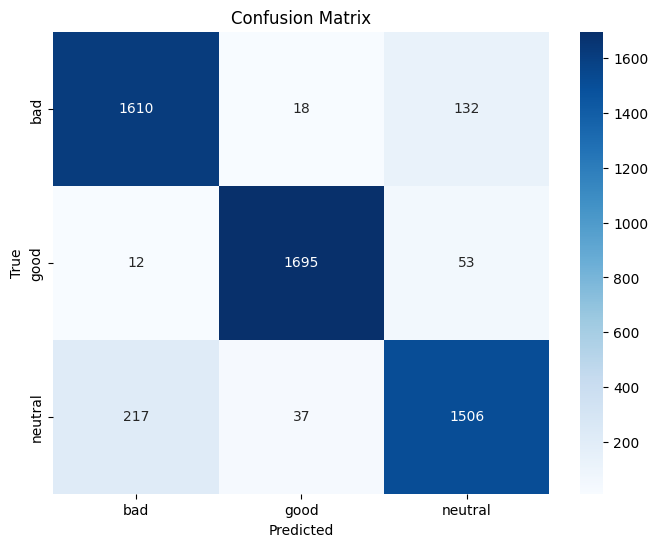

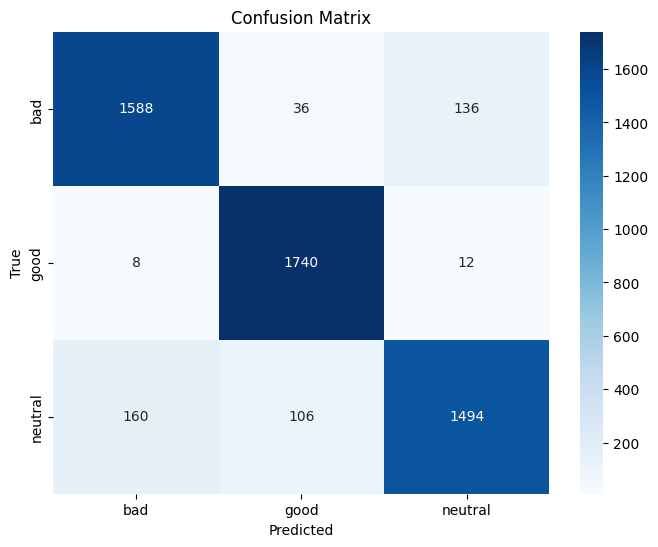

TrainOutput(global_step=1980, training_loss=0.23362172998563208, metrics={'train_runtime': 1361.0973, 'train_samples_per_second': 155.169, 'train_steps_per_second': 4.849, 'total_flos': 4167716536811520.0, 'train_loss': 0.23362172998563208, 'epoch': 3.0})

In [ ]:
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])

# 先把 20% 的數據作為測試集
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Comment'].tolist(),
    df['Rating'].tolist(),
    test_size=0.2,  # 20% 測試集
    random_state=42,
    stratify=df['Rating'].tolist()  # 保持訓練集和測試集的類別比例
)

# 再從剩下的 80% 裡取 20% 當驗證集（相當於原始數據的 16%）
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 20% of 80% = 16%
    random_state=42,
    stratify=train_val_labels  # 保持訓練集和驗證集的類別比例
)

tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert train and validation data to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch (input_ids, attention_mask, and label)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='./results',           # Output directory for saving model
    num_train_epochs=10,               # Number of training epochs
    per_device_train_batch_size=32,   # Batch size for training
    per_device_eval_batch_size=64,# Batch size for evaluation
    load_best_model_at_end=True,
    warmup_steps=300,                 # Number of warmup steps
    weight_decay=0.01,                # Weight decay to avoid overfitting
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=10,                 # How often to log the results
    evaluation_strategy='epoch',      # Evaluate at the end of each epoch
    save_strategy='epoch',            # Save model after each epoch
    report_to='none',                  # Disable reporting to any logging service
    learning_rate=5e-5,
    lr_scheduler_type='cosine'
)

# Function to compute metrics (accuracy, precision, recall, f1)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get predicted classes
    acc = accuracy_score(labels, preds)  # Accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # Precision, recall, F1 score
    cm = confusion_matrix(labels, preds)  # Confusion matrix

    # Convert confusion matrix (which is a numpy ndarray) to a list to avoid serialization error
    cm = cm.tolist()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm  # Return as a list
    }

trainer = Trainer(
    model=model,                      # The model to be trained
    args=training_args,                # Training arguments
    train_dataset=train_dataset,       # Training dataset
    eval_dataset=val_dataset,          # Validation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()



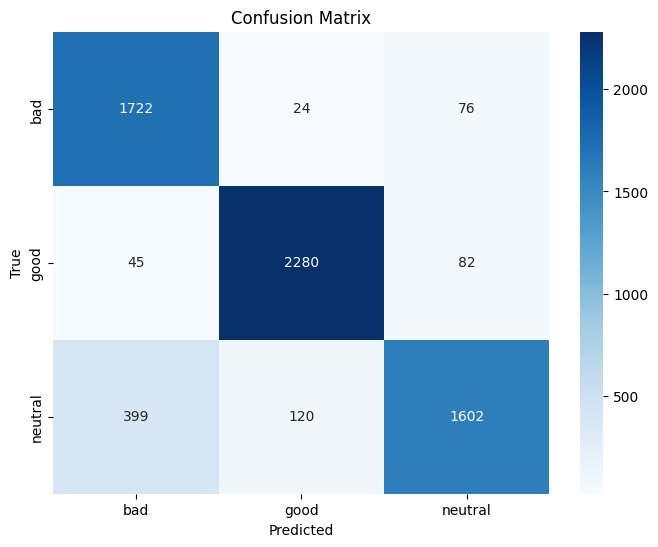

評論: 一分價分貨算不錯啦
真實標籤: neutral  |  預測標籤: neutral
--------------------------------------------------
評論: 卓越網這麼大物流公司真不給力說的號就要到了結果等到號查也查不到打電話沒人接真悲催王老善人的智慧是值得我今生細細品讀的很好
真實標籤: neutral  |  預測標籤: bad
--------------------------------------------------
評論: 前天訂的今天就收到了安裝簡單用紮帶固定了一下每個隔網還算牢固啦不過沒有圖上畫的擱板喲
真實標籤: neutral  |  預測標籤: neutral
--------------------------------------------------
評論: 好吃多汁出貨速度快挪威鯖魚就是讚
真實標籤: good  |  預測標籤: good
--------------------------------------------------
評論: 防曬帽的遮陽效果好但帽子容易變形
真實標籤: neutral  |  預測標籤: neutral
--------------------------------------------------
評論: 第一次遇到没纸箱装没外包装让我从虾皮这样抱回家的很不好拿取
真實標籤: bad  |  預測標籤: bad
--------------------------------------------------
評論: 包裝完整出貨速度快隔天就到貨了
真實標籤: good  |  預測標籤: good
--------------------------------------------------
評論: 白色的很漂亮也很特別很不錯還有送螢幕保護貼
真實標籤: good  |  預測標籤: good
--------------------------------------------------
評論: 有口碑的品牌口感無庸置疑很優惠
真實標籤: good  |  預測標籤: good
--------------------------------------------------
評論: 搞特價所以毫不猶豫地訂了此本書不過

In [ ]:
# 取得模型預測
predictions = trainer.predict(test_dataset)

# 轉換預測結果
predicted_labels = predictions.predictions.argmax(axis=-1)

# 轉回原始標籤名稱
decoded_predictions = label_encoder.inverse_transform(predicted_labels)
decoded_true_labels = label_encoder.inverse_transform(test_labels)

# 印出前 10 筆測試結果，包含評論內容
for i in range(10):
    print(f"評論: {test_texts[i]}")
    print(f"真實標籤: {decoded_true_labels[i]}  |  預測標籤: {decoded_predictions[i]}")
    print("-" * 50)  # 分隔線，讓輸出更清楚


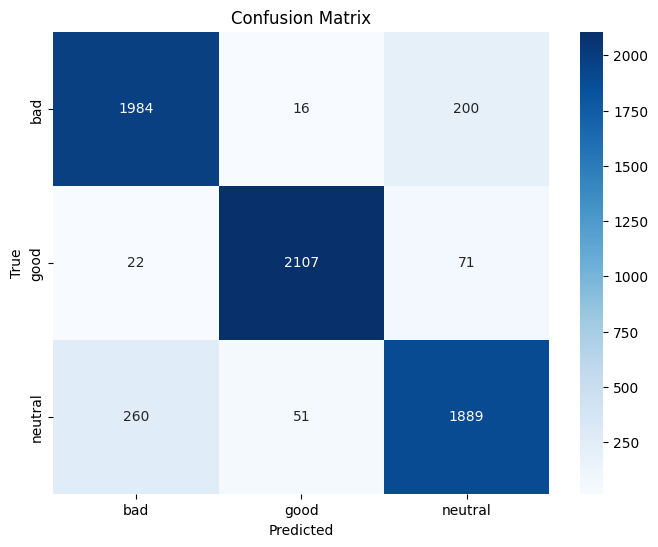

Test Set Results:
{'eval_loss': 0.2469385713338852, 'eval_accuracy': 0.906060606060606, 'eval_precision': 0.9064233008736378, 'eval_recall': 0.906060606060606, 'eval_f1': 0.9061415971089941, 'eval_confusion_matrix': [[1984, 16, 200], [22, 2107, 71], [260, 51, 1889]], 'eval_runtime': 45.6866, 'eval_samples_per_second': 144.462, 'eval_steps_per_second': 2.276, 'epoch': 3.0}


In [ ]:
test_results = trainer.evaluate(test_dataset)

print("Test Set Results:")
print(test_results)

In [ ]:
import numpy as np
from scipy.special import softmax

# 取得模型預測
predictions = trainer.predict(test_dataset)

# 取得 logits 並轉換為機率
logits = predictions.predictions
probabilities = softmax(logits, axis=1)

# 轉換預測結果
predicted_labels = probabilities.argmax(axis=-1)  # 取得機率最高的類別索引
decoded_predictions = label_encoder.inverse_transform(predicted_labels)
decoded_true_labels = label_encoder.inverse_transform(test_labels)

# 印出前 10 筆測試結果，包含評論內容與機率
for i in range(min(100, len(test_texts))):
    predicted_probs = {label: round(prob, 4) for label, prob in zip(label_encoder.classes_, probabilities[i])}  # 轉成標籤名稱
    is_correct = decoded_true_labels[i] == decoded_predictions[i]  # 是否預測正確

    print(f"評論: {test_texts[i]}")
    print(f"真實標籤: {decoded_true_labels[i]}  |  預測標籤: {decoded_predictions[i]} {'✅' if is_correct else '❌'}")
    print(f"各標籤機率: {predicted_probs}")  # 顯示每個標籤的機率
    print("-" * 50)


In [ ]:
# Save the model and tokenizer
model.save_pretrained('./results')  # Save the model in the 'results' folder
tokenizer.save_pretrained('./results')  # Save the tokenizer in the 'results' folder

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# 指定模型的資料夾路徑
MODEL_PATH = "/content/drive/MyDrive/NLP電商專案/final/BERT_results"

# 讀取 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# 讀取模型
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# 確保使用 GPU 加速（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Comment'].tolist(),
    df['Rating'].tolist(),
    test_size=0.2,
    random_state=42
)
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 放到 GPU
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]  # 轉回原始標籤

# 🔹 針對所有評論預測
df["Predicted_Label"] = df["Comment"].apply(predict)

# 🔹 顯示前幾筆結果
print(df.head())

# 🔹 儲存預測結果
df.to_csv("/content/drive/MyDrive/華梵專題/dataset/final_bert_results.csv", index=False, encoding='utf-8-sig')

Map:   0%|          | 0/21120 [00:00<?, ? examples/s]

Map:   0%|          | 0/5280 [00:00<?, ? examples/s]

Map:   0%|          | 0/6600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix,Auc
1,0.262200,0.243508,0.903598,0.904547,0.903598,0.903966,"[[1575, 14, 171], [19, 1672, 69], [210, 26, 1524]]","{0: 0.9779301717458678, 1: 0.9959449251033058, 2: 0.9710144950929753}"
2,0.221700,0.251576,0.909091,0.908997,0.909091,0.909004,"[[1551, 31, 178], [8, 1701, 51], [168, 44, 1548]]","{0: 0.9791273889462809, 1: 0.9952934529958678, 2: 0.9733482373450413}"
3,0.153600,0.310849,0.917424,0.918443,0.917424,0.917098,"[[1641, 9, 110], [21, 1714, 25], [224, 47, 1489]]","{0: 0.9830854532541323, 1: 0.9975101691632232, 2: 0.9777487409607438}"
4,0.046800,0.311256,0.918182,0.919524,0.918182,0.917718,"[[1657, 8, 95], [12, 1716, 32], [238, 47, 1475]]","{0: 0.9814421649018596, 1: 0.9972943569214876, 2: 0.9768324670712809}"
5,0.091600,0.442972,0.922348,0.922770,0.922348,0.922531,"[[1603, 8, 149], [14, 1694, 52], [156, 31, 1573]]","{0: 0.982749790160124, 1: 0.9967956643853306, 2: 0.9771191406249999}"
6,0.011100,0.485699,0.921023,0.921271,0.921023,0.920913,"[[1629, 9, 122], [11, 1706, 43], [192, 40, 1528]]","{0: 0.9829009555785123, 1: 0.9973649761105372, 2: 0.9763297391528926}"
7,0.018700,0.534606,0.922159,0.922647,0.922159,0.922364,"[[1607, 4, 149], [12, 1695, 53], [163, 30, 1567]]","{0: 0.9796446442407024, 1: 0.9966882425103305, 2: 0.9735113474948348}"
8,0.013200,0.558737,0.926136,0.926023,0.926136,0.926074,"[[1608, 10, 142], [7, 1715, 38], [151, 42, 1567]]","{0: 0.976208112732438, 1: 0.9971710356404958, 2: 0.9702786027892562}"
9,0.000800,0.584832,0.924053,0.923887,0.924053,0.923954,"[[1590, 12, 158], [7, 1719, 34], [144, 46, 1570]]","{0: 0.9745360117510329, 1: 0.9971820118801652, 2: 0.9680601110537189}"
10,0.000100,0.584125,0.924621,0.924433,0.924621,0.924517,"[[1596, 12, 152], [8, 1718, 34], [146, 46, 1568]]","{0: 0.9750586744576446, 1: 0.9971703092716943, 2: 0.9687872062241735}"


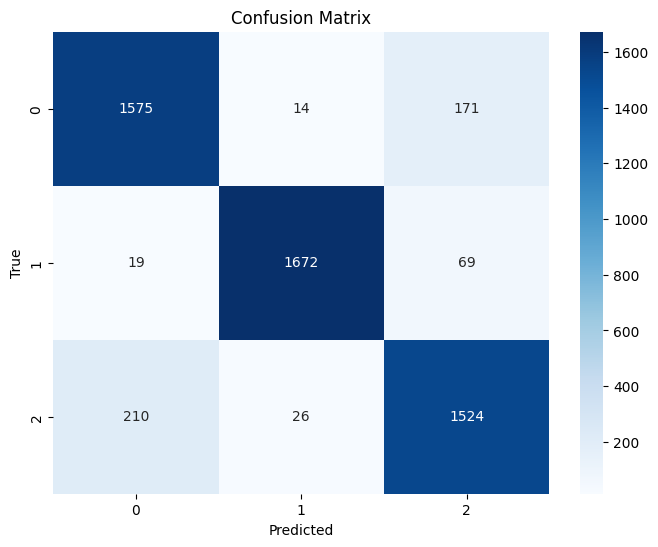

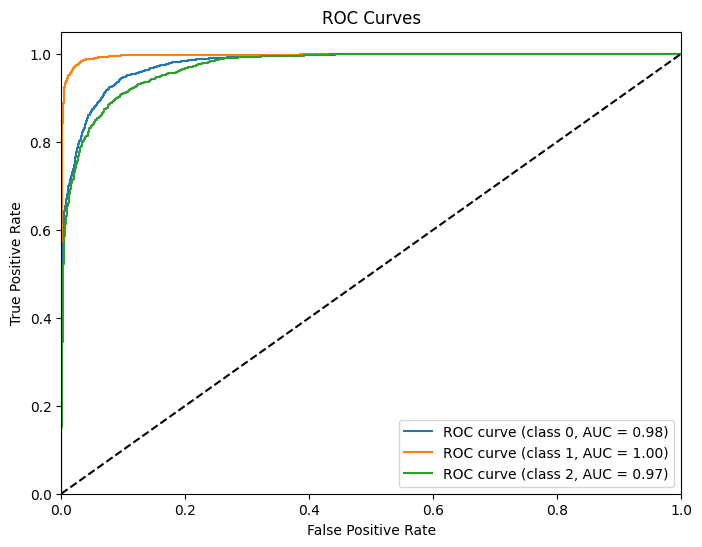

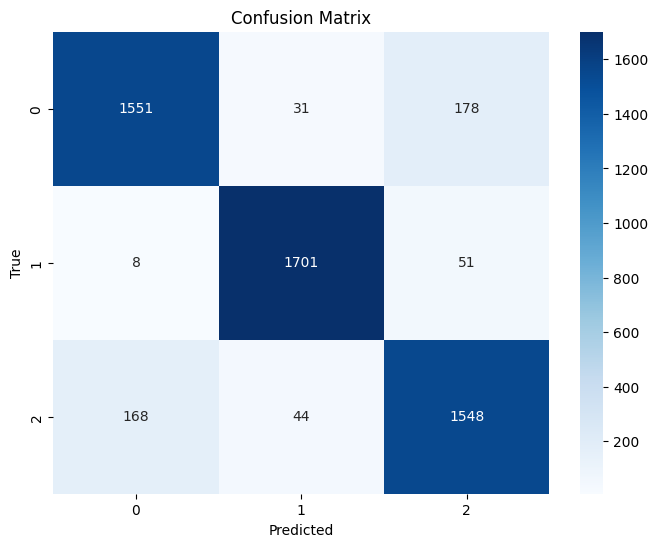

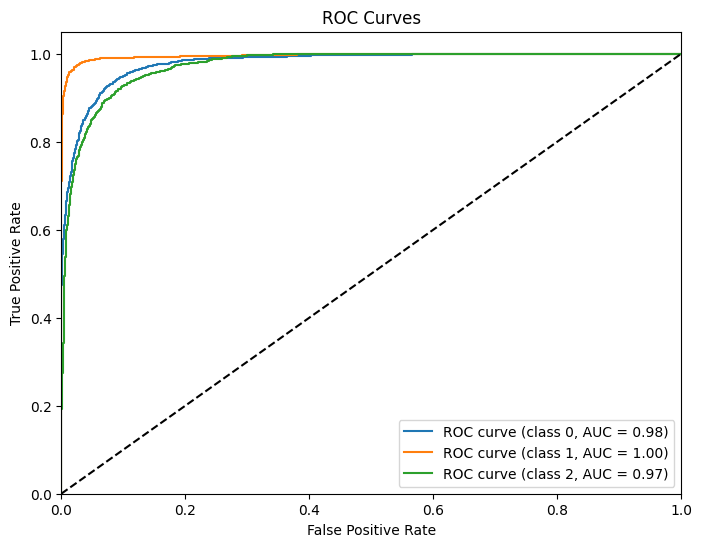

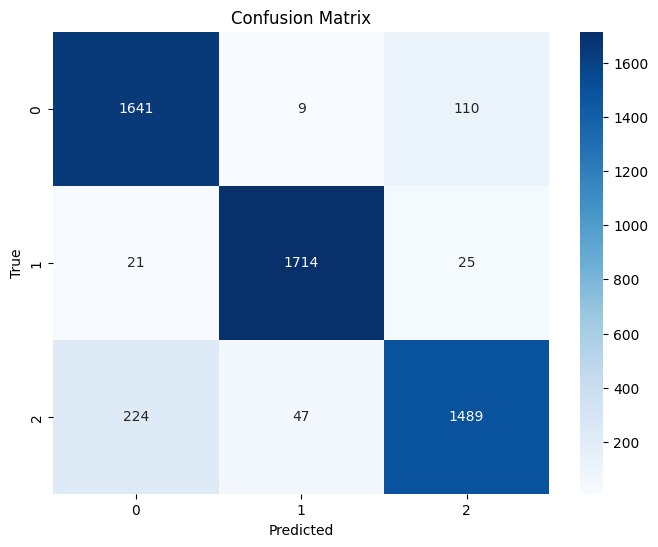

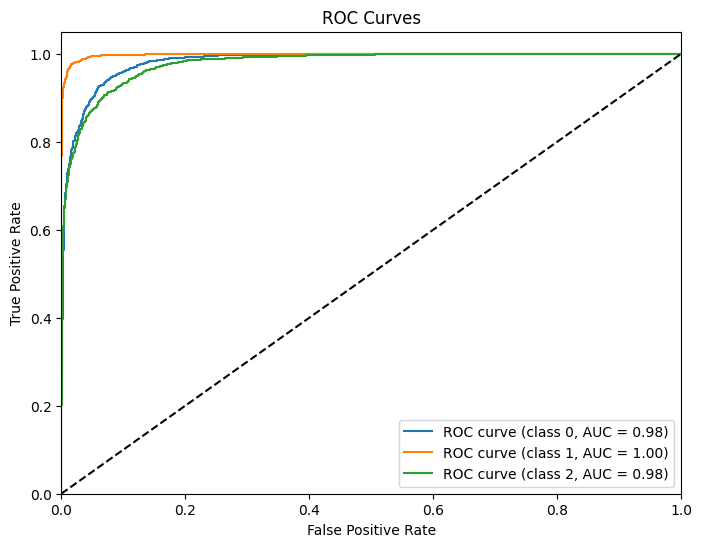

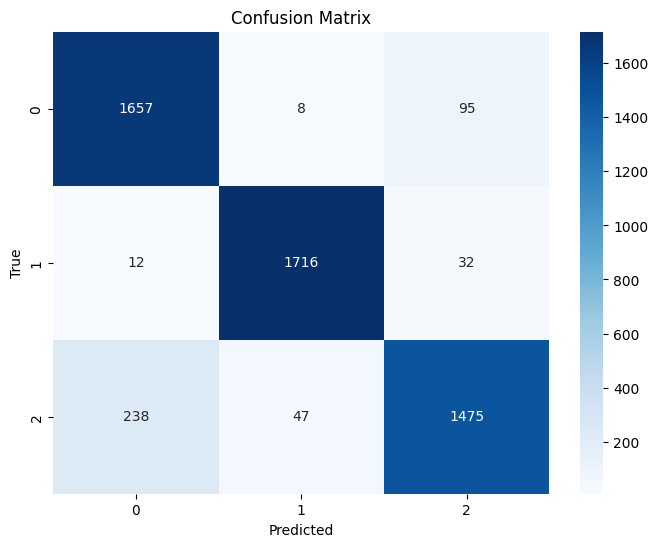

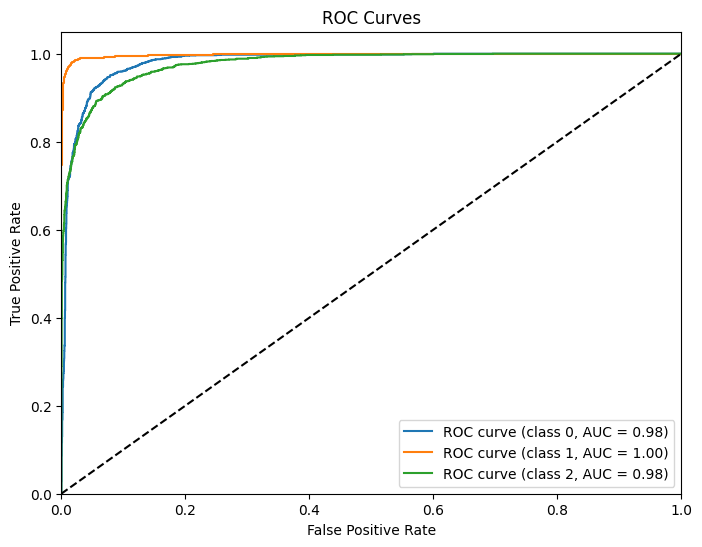

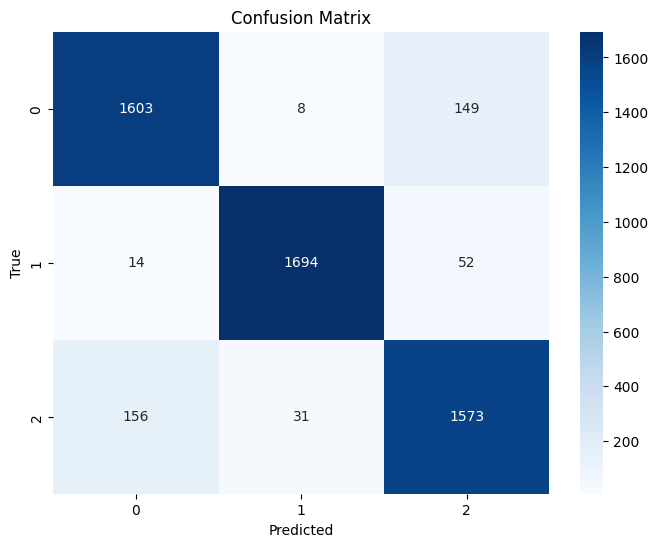

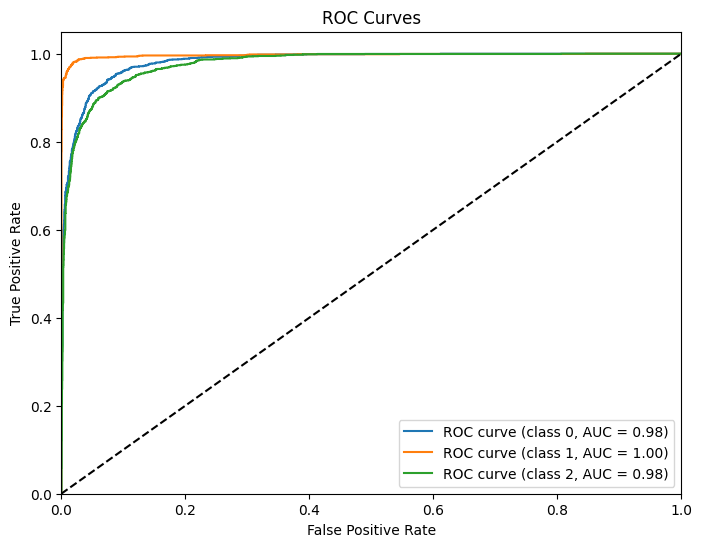

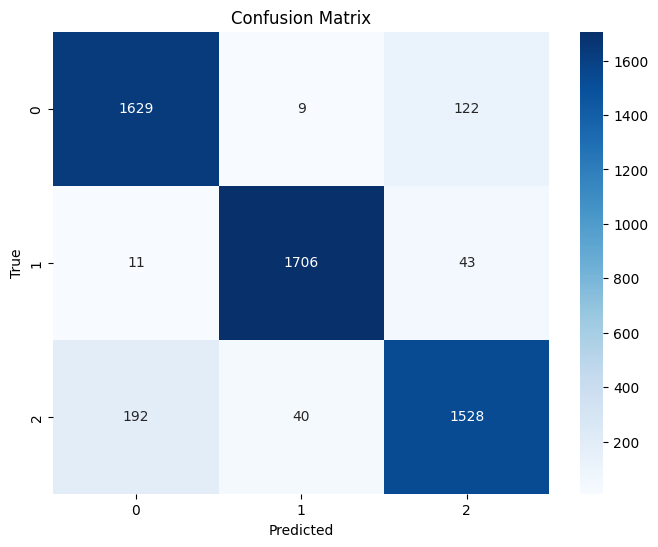

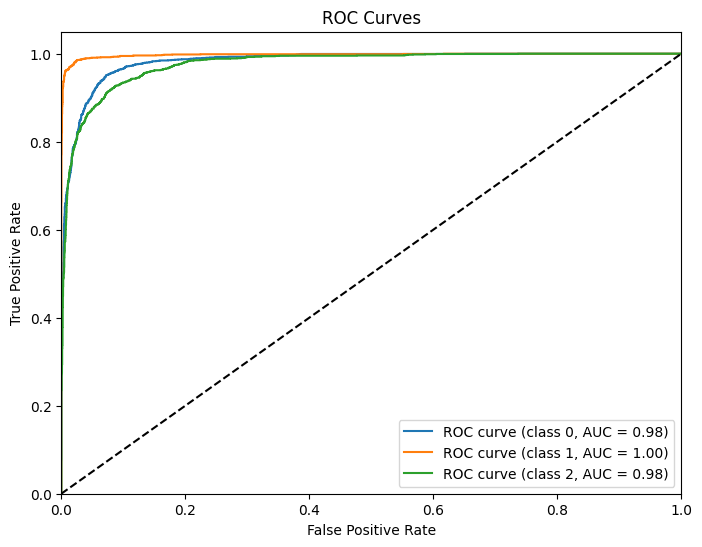

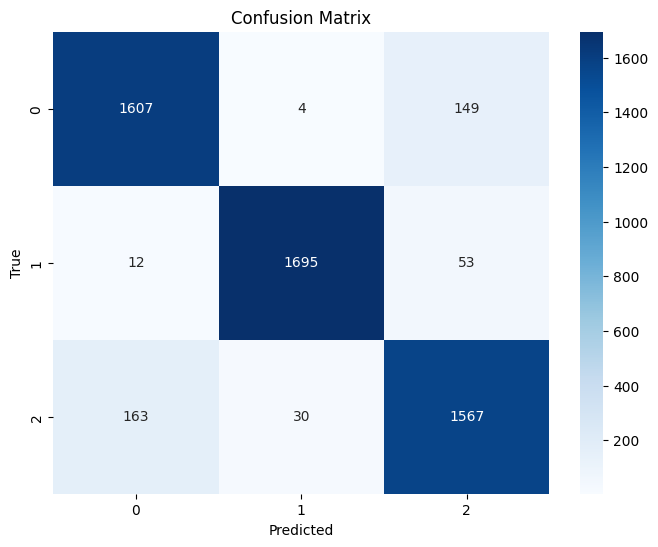

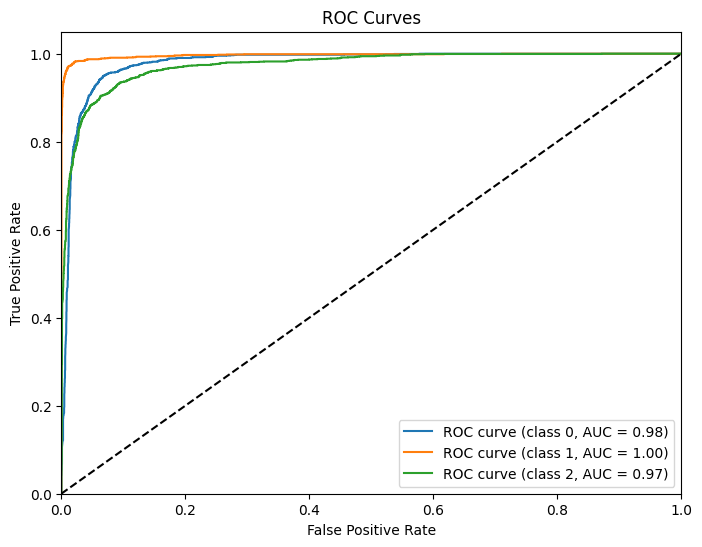

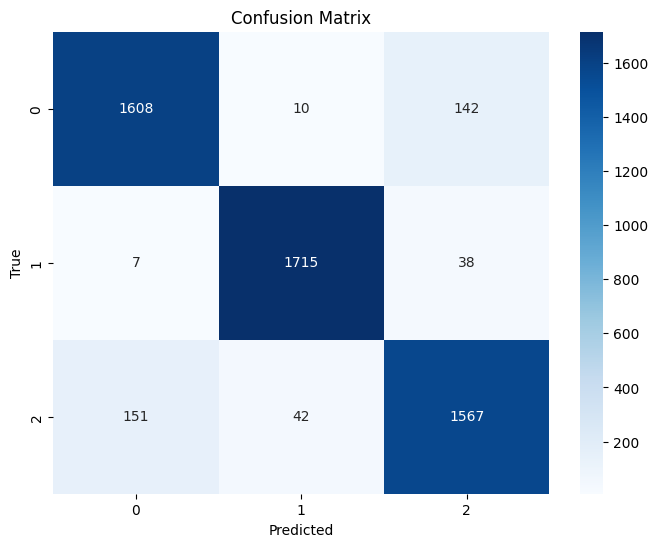

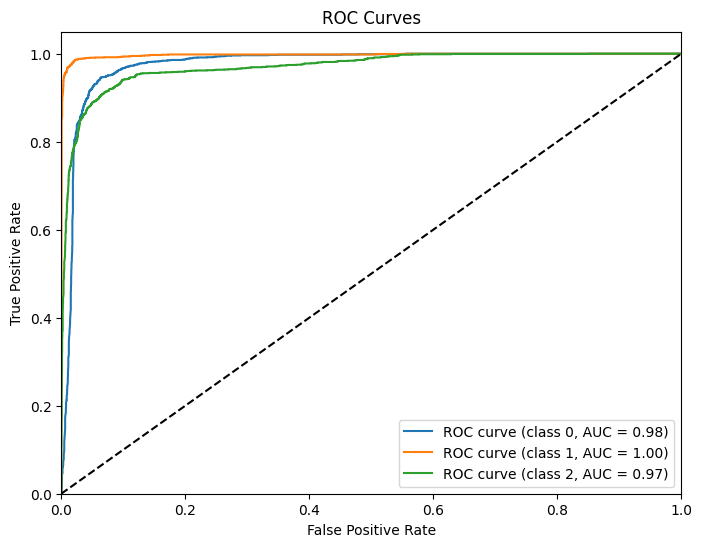

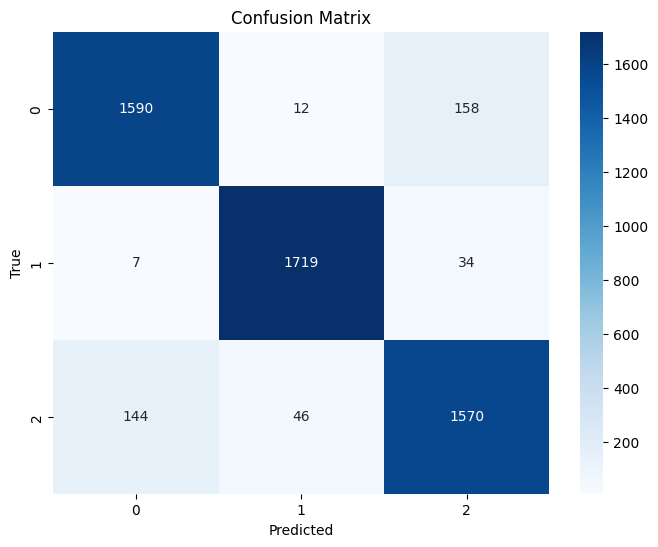

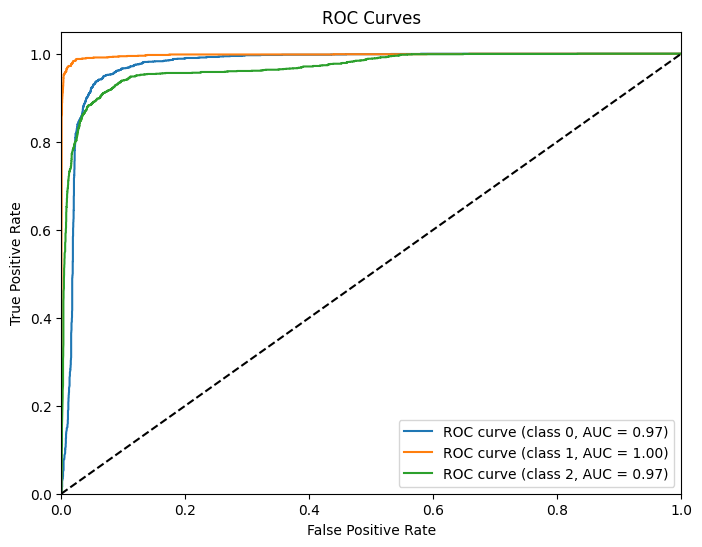

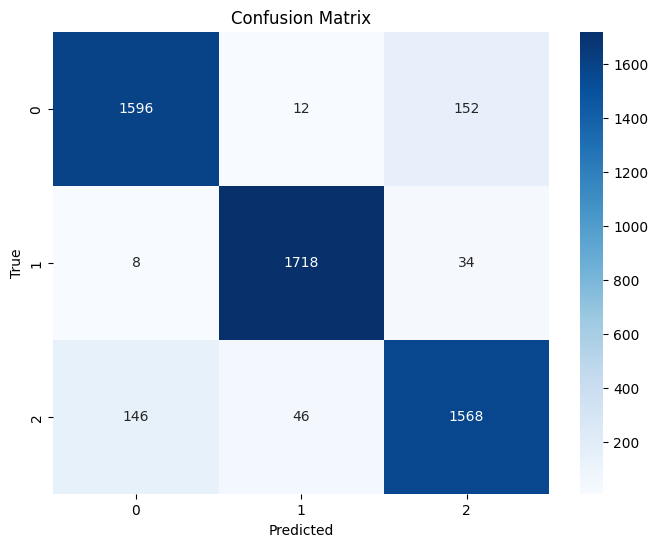

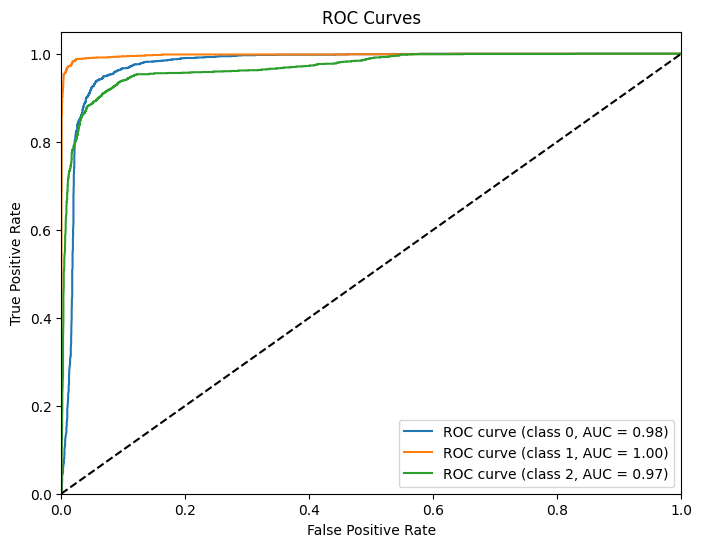

TrainOutput(global_step=6600, training_loss=0.08251827340022745, metrics={'train_runtime': 4404.9971, 'train_samples_per_second': 47.946, 'train_steps_per_second': 1.498, 'total_flos': 1.38923884560384e+16, 'train_loss': 0.08251827340022745, 'epoch': 10.0})

In [ ]:
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])
num_classes = len(label_encoder.classes_)

# 先把 20% 的數據作為測試集
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Comment'].tolist(),
    df['Rating'].tolist(),
    test_size=0.2,  # 20% 測試集
    random_state=42,
    stratify=df['Rating'].tolist()  # 保持訓練集和測試集的類別比例
)

# 再從剩下的 80% 裡取 20% 當驗證集（相當於原始數據的 16%）
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 20% of 80% = 16%
    random_state=42,
    stratify=train_val_labels  # 保持訓練集和驗證集的類別比例
)

tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert train and validation data to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch (input_ids, attention_mask, and label)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=num_classes)

training_args = TrainingArguments(
    output_dir='./results',           # Output directory for saving model
    num_train_epochs=10,              # Number of training epochs
    per_device_train_batch_size=32,   # Batch size for training
    per_device_eval_batch_size=64,    # Batch size for evaluation
    load_best_model_at_end=True,
    warmup_steps=300,                 # Number of warmup steps
    weight_decay=0.01,                # Weight decay to avoid overfitting
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=10,                 # How often to log the results
    evaluation_strategy='epoch',      # Evaluate at the end of each epoch
    save_strategy='epoch',            # Save model after each epoch
    report_to='none',                 # Disable reporting to any logging service
    learning_rate=5e-5,
    lr_scheduler_type='cosine'
)

# Function to compute metrics (accuracy, precision, recall, f1, AUC, ROC)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get predicted classes
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=-1).numpy() # Get probabilities

    acc = accuracy_score(labels, preds)  # Accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # Precision, recall, F1 score
    cm = confusion_matrix(labels, preds)  # Confusion matrix

    # Convert confusion matrix (which is a numpy ndarray) to a list to avoid serialization error
    cm = cm.tolist()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC and AUC for each class (one-vs-rest)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        y_true_binary = (labels == i).astype(int)
        y_score = probs[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {label_encoder.classes_[i]}, AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,  # Return as a list
        'auc': roc_auc #Return auc dict
    }

trainer = Trainer(
    model=model,                       # The model to be trained
    args=training_args,                # Training arguments
    train_dataset=train_dataset,       # Training dataset
    eval_dataset=val_dataset,          # Validation dataset
    compute_metrics=compute_metrics
)

trainer.train()